# Imports

In [ ]:
import numpy as np
import pandas as pd
import json
import datetime

import re
import nltk
from nltk.corpus import stopwords

from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn import datasets, linear_model
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read Categories Json and Trending Data for US

In [ ]:
categories_df = pd.read_json('/content/drive/Shared drives/Google3F_AI_Studio/US_category_id.json')
categories_df = pd.json_normalize(categories_df['items'])[['id', 'snippet.title']]
categories_df = categories_df.rename(columns={'snippet.title': 'title'})

In [ ]:
categories_df.head(30)

,id,title
0,1,Film & Animation
1,2,Autos & Vehicles
2,10,Music
3,15,Pets & Animals
4,17,Sports
5,18,Short Movies
6,19,Travel & Events
7,20,Gaming
8,21,Videoblogging
9,22,People & Blogs


In [ ]:
data_df = pd.read_csv('/content/drive/Shared drives/Google3F_AI_Studio/US_youtube_trending_data.csv')
data_df['publishedAt'] = pd.to_datetime(data_df['publishedAt'], dayfirst=True, format='ISO8601', utc=True)
data_df['trending_date'] = pd.to_datetime(data_df['trending_date'], dayfirst=True, format='ISO8601', utc=True)

# Add a day of the week column
data_df.loc[:, 'published_day_of_week'] = data_df['publishedAt'].dt.day_name()
data_df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,published_day_of_week
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,2020-08-11 19:20:14+00:00,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,2020-08-12 00:00:00+00:00,brawadis|prank|basketball|skits|ghost|funny vi...,1514614,156908,5855,35313,https://i.ytimg.com/vi/3C66w5Z0ixs/default.jpg,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,Tuesday
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,2020-08-11 17:00:10+00:00,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,2020-08-12 00:00:00+00:00,Apex Legends|Apex Legends characters|new Apex ...,2381688,146739,2794,16549,https://i.ytimg.com/vi/M9Pmf9AB4Mo/default.jpg,False,False,"While running her own modding shop, Ramya Pare...",Tuesday
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,2020-08-11 16:34:06+00:00,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,2020-08-12 00:00:00+00:00,jacksepticeye|funny|funny meme|memes|jacksepti...,2038853,353787,2628,40221,https://i.ytimg.com/vi/J78aPJ3VyNs/default.jpg,False,False,I left youtube for a month and this is what ha...,Tuesday
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,2020-08-11 16:38:55+00:00,UCbg_UMjlHJg_19SZckaKajg,XXL,10,2020-08-12 00:00:00+00:00,xxl freshman|xxl freshmen|2020 xxl freshman|20...,496771,23251,1856,7647,https://i.ytimg.com/vi/kXLn3HkpjaA/default.jpg,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,Tuesday
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,2020-08-11 15:10:05+00:00,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,2020-08-12 00:00:00+00:00,The LaBrant Family|DIY|Interior Design|Makeove...,1123889,45802,964,2196,https://i.ytimg.com/vi/VIUo6yapDbc/default.jpg,False,False,Transforming The LaBrant Family's empty white ...,Tuesday


Merge the categories_df into the data_df to add a CategoryName to go with the categoryId so it's more interpretable.

In [ ]:
# Convert 'categoryId' in data_df to string type so a join can be performed
data_df['categoryId'] = data_df['categoryId'].astype(str)
data_df = pd.merge(data_df, categories_df, left_on='categoryId', right_on='id', how='left')
data_df = data_df.rename(columns={'title_x': 'title', 'title_y': 'categoryName'})
# Rearrange columns to place 'categoryName' after 'categoryId'
data_df = data_df[['title', 'publishedAt', 'published_day_of_week', 'channelId', 'channelTitle',
                   'categoryId', 'categoryName', 'trending_date', 'tags', 'view_count',
                   'likes', 'dislikes', 'comment_count','description']]

In [ ]:
data_df.head()
print(data_df.shape)

(268787, 14)


# New LR Model 1

In [ ]:
print(data_df.columns.tolist())

['title', 'publishedAt', 'published_day_of_week', 'channelId', 'channelTitle', 'categoryId', 'categoryName', 'trending_date', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'description']


In [ ]:
# derive total_views, avg_views, and engagement_rate metrics for each channel
# to estimate channel popularity
categories_df = pd.read_json('/content/drive/Shared drives/Google3F_AI_Studio/US_category_id.json')
categories_df = pd.json_normalize(categories_df['items'])[['id', 'snippet.title']]
categories_df = categories_df.rename(columns={'snippet.title': 'title'})

data_df = pd.read_csv('/content/drive/Shared drives/Google3F_AI_Studio/US_youtube_trending_data.csv')
data_df['publishedAt'] = pd.to_datetime(data_df['publishedAt'], dayfirst=True, format='ISO8601', utc=True)
data_df['trending_date'] = pd.to_datetime(data_df['trending_date'], dayfirst=True, format='ISO8601', utc=True)

# Add a day of the week column
data_df.loc[:, 'published_day_of_week'] = data_df['publishedAt'].dt.day_name()
data_df.head()

# Convert 'categoryId' in data_df to string type so a join can be performed
data_df['categoryId'] = data_df['categoryId'].astype(str)
data_df = pd.merge(data_df, categories_df, left_on='categoryId', right_on='id', how='left')
data_df = data_df.rename(columns={'title_x': 'title', 'title_y': 'categoryName'})

# Step 1: Group by 'channelId' and 'channelTitle' to derive total_views, avg_views, and engagement_rate
channel_stats = data_df.groupby(['channelId', 'channelTitle']).agg({
    'view_count': 'sum',      # Sum of view counts for total views
    'likes': 'sum',           # Sum of likes
    'dislikes': 'sum',        # Sum of dislikes
    'comment_count': 'sum',   # Sum of comments
    'video_id': 'count'       # Count the number of videos
}).reset_index()

# Rename 'video_id' count to 'video_count'
channel_stats.rename(columns={'video_id': 'video_count'}, inplace=True)

# Calculate total views
channel_stats['total_views'] = channel_stats['view_count']

# Calculate average views per video
channel_stats['avg_views'] = channel_stats['view_count'] / channel_stats['video_count']

# Calculate engagement rate: (likes + comment_count) / total views
channel_stats['engagement_rate'] = (channel_stats['likes'] + channel_stats['comment_count']) / channel_stats['view_count']

# Step 2: Merge the derived features back into the original DataFrame (df)
# Merge on 'channelId' and 'channelTitle'
df_with_popularity = pd.merge(data_df, channel_stats[['channelId', 'total_views', 'avg_views', 'engagement_rate']], on='channelId', how='left')

# Display the derived features
channel_stats[['channelTitle', 'total_views', 'avg_views', 'engagement_rate']]

# take the log of these derived features
df_with_popularity['log_total_views'] = np.log(df_with_popularity['total_views'])
df_with_popularity['log_avg_views'] = np.log(df_with_popularity['avg_views'])
df_with_popularity['log_engagement_rate'] = np.log(df_with_popularity['engagement_rate'])
data_df = data_df.join(df_with_popularity[['log_total_views', 'log_avg_views', 'log_engagement_rate']])
print(data_df.columns.tolist())

['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId', 'trending_date', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'description', 'published_day_of_week', 'id', 'categoryName', 'log_total_views', 'log_avg_views', 'log_engagement_rate']


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# prompt: get the top 100 channels

# Group the DataFrame by 'channelId' and count the number of videos published by each channel
channel_video_counts = data_df.groupby('channelId')['title'].count().sort_values(ascending=False)

# Get the top 100 channels
df_top_100_channels = channel_video_counts.head(100).index.tolist()

print(df_top_100_channels)

['UCDVYQ4Zhbm3S2dlz7P1GBDg', 'UCWJ2lWNubArHWmf3FIHbfcQ', 'UCX6OQ3DkcsbYNE6H8uQQuVA', 'UCqZQlzSHbVJrwrn5XvzrzcA', 'UCET00YnetHT7tOpu12v8jxg', 'UCRijo3ddMTht_IHyNSNXpNQ', 'UCiWLfSweyRNmLpgEHekhoAg', 'UC3IZKseVpdzPSBaWxBxundA', 'UCo_IB5145EVNcf8hw1Kku7w', 'UCPD_bxCRGpmmeQcbe2kpPaA', 'UCke6I9N4KfC968-yRcd5YRg', 'UCGIY_O-8vW4rfX98KlMkvRg', 'UCurvRE5fGcdUgCYWgh-BDsg', 'UCpB959t8iPrxQWj7G6n0ctQ', 'UCqFzWxSCi39LnW1JKFR3efg', 'UCvC4D8onUfXzvjTOM-dBfEA', 'UCaO6TYtlC8U5ttz62hTrZgg', 'UCHnyfMqiRRG1u-2MsSQLbXA', 'UCiS882YPwZt1NfaM0gR0D9Q', 'UClG8odDC8TS6Zpqk9CGVQiQ', 'UCnmGIkw-KdI0W5siakKPKog', 'UC3sznuotAs2ohg_U__Jzj_Q', 'UC0ZV6M2THA81QT9hrVWJG3A', 'UCIPPMRA040LQr5QPyJEbmXA', 'UCEf_Bc-KVd7onSeifS3py9g', 'UCtI0Hodo5o5dUb67FeUjDeA', 'UCHYoe8kQ-7Gn9ASOlmI0k6Q', 'UCWOA1ZGywLbqmigxE4Qlvuw', 'UC6c1z7bA__85CIWZ_jpCK-Q', 'UCD1Em4q90ZUK2R5HKesszJg', 'UCLXzq85ijg2LwJWFrz4pkmw', 'UCJ5v_MCY6GNUBTO8-D3XoAg', 'UCB_qr75-ydFVKSF9Dmo6izg', 'UCT2X19JJaJGUN7mrYuImANQ', 'UCLkAepWjdylmXSltofFvsYQ', 'UCBJycsmduvYEL83R_

In [ ]:
# prompt: one hot encode the top 100 channels with onehotenc

# Create a new column 'channelId_encoded' with 0 for all channels
data_df['channelId_encoded'] = 0

# Iterate through the top 100 channels and assign a unique integer encoding
for i, channel in enumerate(df_top_100_channels):
  data_df.loc[data_df['channelId'] == channel, 'channelId_encoded'] = i + 1

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the 'channelId_encoded' column
enc.fit(data_df[['channelId_encoded']])

# Transform the 'channelId_encoded' column into a one-hot encoded matrix
onehotlabels = enc.transform(data_df[['channelId_encoded']]).toarray()

# Create a new DataFrame with the one-hot encoded columns
onehot_channel_df = pd.DataFrame(onehotlabels, columns=['channel_' + str(i) for i in range(onehotlabels.shape[1])])

# Concatenate the original DataFrame and the one-hot encoded DataFrame
data_df = pd.concat([data_df, onehot_channel_df], axis=1)

In [ ]:
# prompt: print out the list of encoded channels

print(onehot_channel_df.columns.tolist())

['channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'channel_47', 'channel_48', 'channel_49', 'channel_50', 'channel_51', 'channel_52', 'channel_53', 'channel_54', 'channel_55', 'channel_56', 'channel_57', 'channel_58', 'channel_59', 'channel_60', 'channel_61', 'channel_62', 'channel_63', 'channel_64', 'channel_65', 'channel_66', 'channel_67', 'channel_68', 'channel_69', 'channel_70', 'channel_71', '

In [ ]:
# features: days_since_published, square_of_days_since_published, sqrt_days_since_published, log_days_since_published
data_df['days_since_published'] = (data_df['trending_date'] - data_df['publishedAt']).dt.days + 2

data_df['log_view_velocity'] = np.log(data_df['view_count'] + 1) / data_df['days_since_published']
data_df['view_velocity'] = data_df['view_count']+1 / data_df['days_since_published']+1

data_df['log_days_since_published'] = np.log(data_df['days_since_published'])
data_df['square_of_days_since_published'] = data_df['days_since_published'] ** 2
data_df['sqrt_days_since_published'] = np.sqrt(data_df['days_since_published'])


# Calculate the mean of the 'view_velocity' column (or whichever column you want to use)
mean = data_df['view_velocity'].mean()

# Fill NaN values in 'data_df' with the calculated mean
data_df.fillna(value=mean, inplace=True)

In [ ]:
# prompt: get the top 15 categories
top_15_categories = data_df.groupby('categoryName')['video_id'].count().sort_values(ascending=False).head(15)
print(top_15_categories)

categoryName
Entertainment            53934
Gaming                   53242
Music                    43398
Sports                   31327
People & Blogs           22653
Comedy                   13183
Film & Animation         10923
News & Politics           9669
Science & Technology      8156
Howto & Style             7100
Education                 6655
Autos & Vehicles          5492
Travel & Events           1713
Pets & Animals            1222
Nonprofits & Activism      120
Name: video_id, dtype: int64


In [ ]:
# prompt: one hot encode the top 15 categories with onehotenc

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the 'categoryName' column, considering only the top 15 categories
enc.fit(data_df[['categoryName']].loc[data_df['categoryName'].isin(top_15_categories.index)])

# Transform the 'categoryName' column into a one-hot encoded matrix
onehotlabels = enc.transform(data_df[['categoryName']]).toarray()

# Create a new DataFrame with the one-hot encoded columns
onehot_category_df = pd.DataFrame(onehotlabels, columns=['category_' + str(i) for i in range(onehotlabels.shape[1])])

# Concatenate the original DataFrame and the one-hot encoded DataFrame
data_df = pd.concat([data_df, onehot_category_df], axis=1)

In [ ]:
print(onehot_category_df.columns.tolist())

['category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13', 'category_14']


In [ ]:
# prompt: get the day of the week published and one hot encode them with onehotenc

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the 'published_day_of_week' column
enc.fit(data_df[['published_day_of_week']])

# Transform the 'published_day_of_week' column into a one-hot encoded matrix
onehotlabels = enc.transform(data_df[['published_day_of_week']]).toarray()

# Create a new DataFrame with the one-hot encoded columns
onehot_day_df = pd.DataFrame(onehotlabels, columns=['day_' + str(i) for i in range(onehotlabels.shape[1])])

# Concatenate the original DataFrame and the one-hot encoded DataFrame
data_df = pd.concat([data_df, onehot_day_df], axis=1)

In [ ]:
print(onehot_day_df.columns.tolist())

['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']


In [ ]:
# prompt: change my time split to this: Training set: Between Jan 1, 2023 & Dec 31, 2023
# Validation set: Between Dec 31, 2023 & Feb 18, 2024
# Test set: After Feb 18, 2024

# Define the time splits
train_start_date = datetime.date(2023, 1, 1)
train_end_date = datetime.date(2023, 12, 31)
validation_start_date = datetime.date(2023, 12, 31)
validation_end_date = datetime.date(2024, 2, 18)

# Create training, validation, and test sets based on the trending_date
training_df = data_df[(data_df['trending_date'].dt.date >= train_start_date) & (data_df['trending_date'].dt.date <= train_end_date)]
validation_df = data_df[(data_df['trending_date'].dt.date >= validation_start_date) & (data_df['trending_date'].dt.date <= validation_end_date)]
test_df = data_df[data_df['trending_date'].dt.date > validation_end_date]

In [ ]:
from datetime import datetime, timezone

data_df['publishedAt'] = pd.to_datetime(data_df['publishedAt'])

# splitting training and test sets by time
# Make the comparison datetime timezone-aware
training_df = data_df[(data_df['publishedAt'].dt.year == 2024) & (data_df['publishedAt'] < datetime(2024, 2, 18, tzinfo=timezone.utc))]
test_df = data_df[(data_df['publishedAt'].dt.year >= 2024) & (data_df['publishedAt'] >= datetime(2024, 2, 18, tzinfo=timezone.utc))]

print(f"Train data shape: {training_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (9586, 152)
Test data shape: (10616, 152)


In [ ]:
# Select numerical columns
numerical_cols = ['square_of_days_since_published', 'sqrt_days_since_published', 'log_days_since_published']

# Remove rows with NaN values in numerical_cols
data_df.dropna(subset=numerical_cols, inplace=True)

In [ ]:
# normalize the numerical columns
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Replace infinite values with NaN
data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fit and transform the numerical columns
data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])

In [ ]:
print(data_df.columns.tolist())

['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId', 'trending_date', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'description', 'published_day_of_week', 'id', 'categoryName', 'log_total_views', 'log_avg_views', 'log_engagement_rate', 'channelId_encoded', 'channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel

In [ ]:
# features: days since published, sqaure of days since published, sqrt of days since published, log day since published,
#           day of week published, top 15 categories, top 100 channels
y_train = training_df['log_view_velocity']
X_train = training_df[['days_since_published', 'square_of_days_since_published', 'sqrt_days_since_published', 'log_days_since_published',
                       'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
                       'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13', 'category_14',
                       'channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'channel_47', 'channel_48', 'channel_49', 'channel_50', 'channel_51', 'channel_52', 'channel_53', 'channel_54', 'channel_55', 'channel_56', 'channel_57', 'channel_58', 'channel_59', 'channel_60', 'channel_61', 'channel_62', 'channel_63', 'channel_64', 'channel_65', 'channel_66', 'channel_67', 'channel_68', 'channel_69', 'channel_70', 'channel_71', 'channel_72', 'channel_73', 'channel_74', 'channel_75', 'channel_76', 'channel_77', 'channel_78', 'channel_79', 'channel_80', 'channel_81', 'channel_82', 'channel_83', 'channel_84', 'channel_85', 'channel_86', 'channel_87', 'channel_88', 'channel_89', 'channel_90', 'channel_91', 'channel_92', 'channel_93', 'channel_94', 'channel_95', 'channel_96', 'channel_97', 'channel_98', 'channel_99', 'channel_100']]

y_validation_df = validation_df['log_view_velocity']
X_validation_df = validation_df[['days_since_published', 'square_of_days_since_published', 'sqrt_days_since_published', 'log_days_since_published',
                       'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
                       'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13', 'category_14',
                       'channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'channel_47', 'channel_48', 'channel_49', 'channel_50', 'channel_51', 'channel_52', 'channel_53', 'channel_54', 'channel_55', 'channel_56', 'channel_57', 'channel_58', 'channel_59', 'channel_60', 'channel_61', 'channel_62', 'channel_63', 'channel_64', 'channel_65', 'channel_66', 'channel_67', 'channel_68', 'channel_69', 'channel_70', 'channel_71', 'channel_72', 'channel_73', 'channel_74', 'channel_75', 'channel_76', 'channel_77', 'channel_78', 'channel_79', 'channel_80', 'channel_81', 'channel_82', 'channel_83', 'channel_84', 'channel_85', 'channel_86', 'channel_87', 'channel_88', 'channel_89', 'channel_90', 'channel_91', 'channel_92', 'channel_93', 'channel_94', 'channel_95', 'channel_96', 'channel_97', 'channel_98', 'channel_99', 'channel_100']]

y_test = test_df['log_view_velocity']
X_test = test_df[['days_since_published', 'square_of_days_since_published', 'sqrt_days_since_published', 'log_days_since_published',
                       'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
                       'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13', 'category_14',
                       'channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'channel_47', 'channel_48', 'channel_49', 'channel_50', 'channel_51', 'channel_52', 'channel_53', 'channel_54', 'channel_55', 'channel_56', 'channel_57', 'channel_58', 'channel_59', 'channel_60', 'channel_61', 'channel_62', 'channel_63', 'channel_64', 'channel_65', 'channel_66', 'channel_67', 'channel_68', 'channel_69', 'channel_70', 'channel_71', 'channel_72', 'channel_73', 'channel_74', 'channel_75', 'channel_76', 'channel_77', 'channel_78', 'channel_79', 'channel_80', 'channel_81', 'channel_82', 'channel_83', 'channel_84', 'channel_85', 'channel_86', 'channel_87', 'channel_88', 'channel_89', 'channel_90', 'channel_91', 'channel_92', 'channel_93', 'channel_94', 'channel_95', 'channel_96', 'channel_97', 'channel_98', 'channel_99', 'channel_100']]

In [ ]:
# Re-check X_train and y_train before model fitting
print("Any infinities in X_train?", np.isinf(X_train).sum().sum())
print("Any NaNs in X_train?", np.isnan(X_train).sum().sum())
print("Any infinities in y_train?", np.isinf(y_train).sum())
print("Any NaNs in y_train?", np.isnan(y_train).sum())

print("Any infinities in X_test?", np.isinf(X_test).sum().sum())
print("Any NaNs in X_test?", np.isnan(X_test).sum().sum())
print("Any infinities in y_test?", np.isinf(y_test).sum())
print("Any NaNs in y_test?", np.isnan(y_test).sum())

Any infinities in X_train? 0
Any NaNs in X_train? 0
Any infinities in y_train? 0
Any NaNs in y_train? 0
Any infinities in X_test? 0
Any NaNs in X_test? 0
Any infinities in y_test? 0
Any NaNs in y_test? 0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# fit the model with cleaned data
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# predict and calculate MSE on logged values
y_pred = model.predict(X_test)
y_test = y_test.loc[X_test.index]

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# applying the exponential function to get back to the original scale
y_test_original = np.exp(y_test)
y_pred_original = np.exp(y_pred)

Mean Squared Error: 0.07450680586438224


In [ ]:
# prompt: can u give me the validation mse too

# predict and calculate MSE on validation set
y_pred_validation = model.predict(X_validation_df)
y_validation_df = y_validation_df.loc[X_validation_df.index]

validation_mse = mean_squared_error(y_validation_df, y_pred_validation)
print(f"Validation Mean Squared Error: {validation_mse}")

Validation Mean Squared Error: 0.06420537295749226


In [ ]:
# prompt: get the rsme for the validation and test df

from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming you have already trained your model and have predictions for validation and test sets

# Calculate RMSE for validation set
rmse_validation = np.sqrt(mean_squared_error(y_validation_df, y_pred_validation))
print(f"Validation RMSE: {rmse_validation}")


# Calculate RMSE for test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse_test}")

Validation RMSE: 0.2533877916504508
Test RMSE: 0.27295934837331043


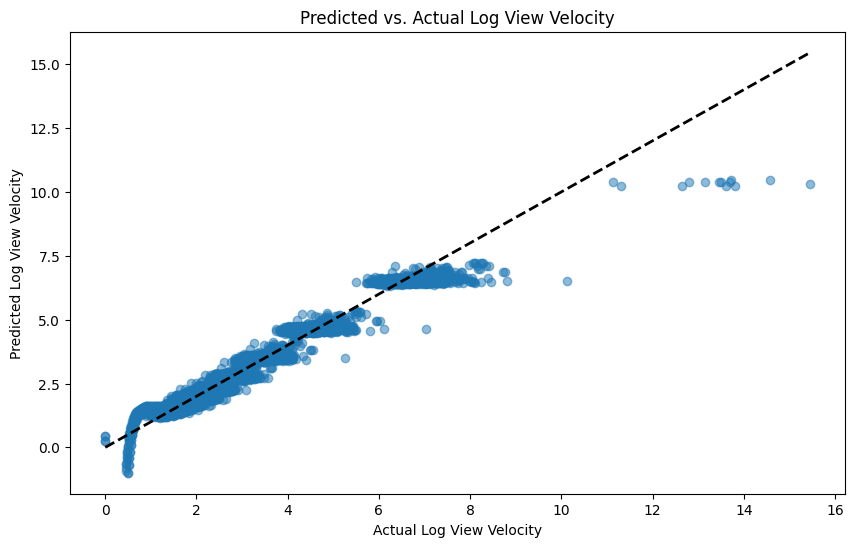

In [ ]:
# prompt: plot predicted vs actual values for the log view velocity from the model ran above

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Log View Velocity")
plt.ylabel("Predicted Log View Velocity")
plt.title("Predicted vs. Actual Log View Velocity")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Adding a diagonal line
plt.show()

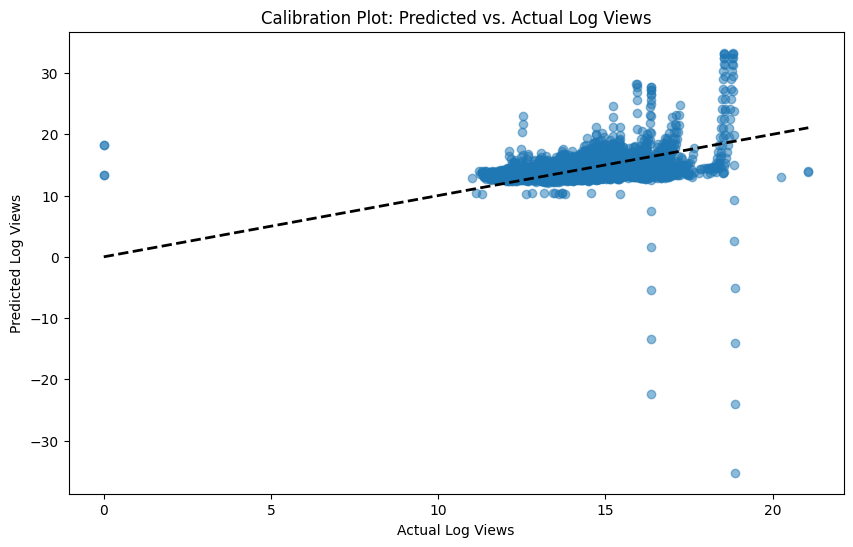

In [ ]:
# create the calibration plot (True vs predicted value) using the log(views).

# Multiply actual and predicted log view velocity by days since published
y_test_multiplied = y_test * test_df['days_since_published']
y_pred_multiplied = y_pred * test_df['days_since_published']

# Create the scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_multiplied, y_pred_multiplied, alpha=0.5)
plt.xlabel("Actual Log Views")
plt.ylabel("Predicted Log Views")
plt.title("Calibration Plot: Predicted vs. Actual Log Views")
plt.plot([y_test_multiplied.min(), y_test_multiplied.max()], [y_test_multiplied.min(), y_test_multiplied.max()], 'k--', lw=2)  # Add a diagonal line
plt.show()

<ipython-input-39-5eeebf96ff32>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['difference'] = difference


                                                    title  \
267306             I Survived 7 Days In An Abandoned City   
267108             I Survived 7 Days In An Abandoned City   
268278  KNOCKOUT CHAOS | Anthony Joshua vs. Francis Ng...   
266915             I Survived 7 Days In An Abandoned City   
268090  KNOCKOUT CHAOS | Anthony Joshua vs. Francis Ng...   
266700             I Survived 7 Days In An Abandoned City   
267874  KNOCKOUT CHAOS | Anthony Joshua vs. Francis Ng...   
268388         Coachella Stage 🔴 Live from Coachella 2024   
268393                  Sahara 🔴 Live from Coachella 2024   
266501             I Survived 7 Days In An Abandoned City   
267674  KNOCKOUT CHAOS | Anthony Joshua vs. Francis Ng...   
267297                 Stop This Train, Win a Lamborghini   
267516                 Stop This Train, Win a Lamborghini   
267102                 Stop This Train, Win a Lamborghini   
264503             I Survived 7 Days In An Abandoned City   
264698             I Sur

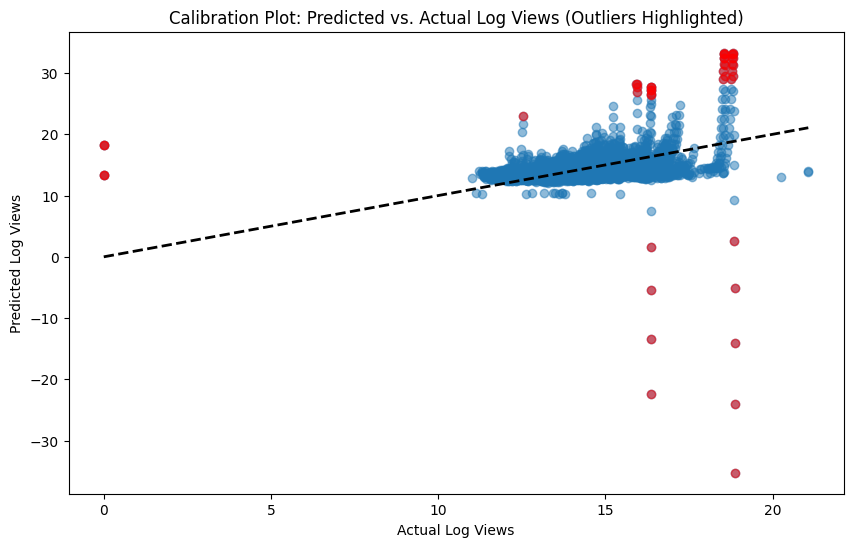

In [ ]:
# prompt: calculate the difference between the actual and predicted values, then examine the characteristics of these videos (channel, category, publication date, etc.) to understand the reasons behind the deviations.

# Calculate the difference between actual and predicted log views
difference = y_test_multiplied - y_pred_multiplied

# Add the difference as a new column to the test_df
test_df['difference'] = difference

# Sort the test_df by the absolute difference in descending order to find the largest deviations
test_df_sorted = test_df.sort_values(by='difference', key=abs, ascending=False)

# Examine the characteristics of the top 50 outliers
top_50_outliers = test_df_sorted.head(50)
print(top_50_outliers[['title', 'channelTitle', 'categoryName', 'publishedAt', 'trending_date', 'view_count', 'log_view_velocity', 'difference']])

# You can further analyze these outliers by:
# 1. Investigating the content of the videos: Does the video topic, title, or description have any commonalities?
# 2. Examining the channel characteristics: Are the outliers primarily from specific channels or channel types?
# 3. Looking at the publication date and trending date: Are there any specific trends or seasonal effects related to the outliers?

# You can also visualize the outliers in the calibration plot by highlighting them using different colors or markers.
# For example, you can plot the points with a larger difference in a different color:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_multiplied, y_pred_multiplied, alpha=0.5)
plt.scatter(y_test_multiplied[abs(difference) > 10], y_pred_multiplied[abs(difference) > 10], color='red', alpha=0.5)  # Highlight outliers with a difference larger than 10
plt.xlabel("Actual Log Views")
plt.ylabel("Predicted Log Views")
plt.title("Calibration Plot: Predicted vs. Actual Log Views (Outliers Highlighted)")
plt.plot([y_test_multiplied.min(), y_test_multiplied.max()], [y_test_multiplied.min(), y_test_multiplied.max()], 'k--', lw=2)
plt.show()


In [ ]:
# prompt: further analyze these outliers by:
# 1. Investigating the content of the videos
# Analyze the titles and descriptions of the outlier videos
#for index, row in top_50_outliers.iterrows():
  #print(f"Video Title: {row['title']}")
  #print(f"Video Description (if available): {row['description']}")

# 2. Examining the channel characteristics
# Group the outliers by channel and analyze channel-specific trends
outlier_channel_stats = top_50_outliers.groupby('channelTitle')['video_id'].count().sort_values(ascending=False)
print("Outlier Channel Stats:")
print(outlier_channel_stats)

# 3. Looking at the publication date and trending date
# Analyze the publication and trending dates to identify any patterns or seasonal effects
outlier_dates = top_50_outliers[['publishedAt', 'trending_date']]
print("Outlier Publication and Trending Dates:")
print(outlier_dates)

# Further analysis using NLP and topic modeling
# You can use NLP libraries like NLTK or spaCy to process video titles and descriptions, extract keywords, and perform topic modeling to discover common themes in the outlier videos.
# You can also analyze the sentiment of the video descriptions to see if there are any specific emotional responses associated with the outliers.

# Example of analyzing video titles for keywords
stop_words = set(stopwords.words('english'))
all_titles = " ".join(top_50_outliers['title'].astype(str))
title_words = re.findall(r'\b\w+\b', all_titles.lower())
title_words = [word for word in title_words if word not in stop_words]
word_counts = Counter(title_words)
print("Most frequent words in outlier video titles:")
print(word_counts.most_common(10))

Outlier Channel Stats:
channelTitle
MrBeast                        27
DAZN Boxing                    11
The Emirates FA Cup             5
Coachella                       4
NRL - National Rugby League     2
WWE                             1
Name: video_id, dtype: int64
Outlier Publication and Trending Dates:
                     publishedAt             trending_date
267306 2024-03-02 17:00:00+00:00 2024-04-08 00:00:00+00:00
267108 2024-03-02 17:00:00+00:00 2024-04-07 00:00:00+00:00
268278 2024-03-09 02:47:43+00:00 2024-04-13 00:00:00+00:00
266915 2024-03-02 17:00:00+00:00 2024-04-06 00:00:00+00:00
268090 2024-03-09 02:47:43+00:00 2024-04-12 00:00:00+00:00
266700 2024-03-02 17:00:00+00:00 2024-04-05 00:00:00+00:00
267874 2024-03-09 02:47:43+00:00 2024-04-11 00:00:00+00:00
268388 2024-03-15 20:20:45+00:00 2024-04-14 00:00:00+00:00
268393 2024-03-15 20:27:26+00:00 2024-04-14 00:00:00+00:00
266501 2024-03-02 17:00:00+00:00 2024-04-04 00:00:00+00:00
267674 2024-03-09 02:47:43+00:00 2024-04-1

# New LR Model 2 w/ derived features

In [ ]:
print(data_df.columns.tolist())

['title', 'publishedAt', 'published_day_of_week', 'channelId', 'channelTitle', 'categoryId', 'categoryName', 'trending_date', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'description']


In [ ]:
# derive total_views, avg_views, and engagement_rate metrics for each channel
# to estimate channel popularity
categories_df = pd.read_json('/content/drive/Shared drives/Google3F_AI_Studio/US_category_id.json')
categories_df = pd.json_normalize(categories_df['items'])[['id', 'snippet.title']]
categories_df = categories_df.rename(columns={'snippet.title': 'title'})

data_df = pd.read_csv('/content/drive/Shared drives/Google3F_AI_Studio/US_youtube_trending_data.csv')
data_df['publishedAt'] = pd.to_datetime(data_df['publishedAt'], dayfirst=True, format='ISO8601', utc=True)
data_df['trending_date'] = pd.to_datetime(data_df['trending_date'], dayfirst=True, format='ISO8601', utc=True)

# Add a day of the week column
data_df.loc[:, 'published_day_of_week'] = data_df['publishedAt'].dt.day_name()
data_df.head()

# Convert 'categoryId' in data_df to string type so a join can be performed
data_df['categoryId'] = data_df['categoryId'].astype(str)
data_df = pd.merge(data_df, categories_df, left_on='categoryId', right_on='id', how='left')
data_df = data_df.rename(columns={'title_x': 'title', 'title_y': 'categoryName'})

# Step 1: Group by 'channelId' and 'channelTitle' to derive total_views, avg_views, and engagement_rate
channel_stats = data_df.groupby(['channelId', 'channelTitle']).agg({
    'view_count': 'sum',      # Sum of view counts for total views
    'likes': 'sum',           # Sum of likes
    'dislikes': 'sum',        # Sum of dislikes
    'comment_count': 'sum',   # Sum of comments
    'video_id': 'count'       # Count the number of videos
}).reset_index()

# Rename 'video_id' count to 'video_count'
channel_stats.rename(columns={'video_id': 'video_count'}, inplace=True)

# Calculate total views
channel_stats['total_views'] = channel_stats['view_count']

# Calculate average views per video
channel_stats['avg_views'] = channel_stats['view_count'] / channel_stats['video_count']

# Calculate engagement rate: (likes + comment_count) / total views
channel_stats['engagement_rate'] = (channel_stats['likes'] + channel_stats['comment_count']) / channel_stats['view_count']

# Step 2: Merge the derived features back into the original DataFrame (df)
# Merge on 'channelId' and 'channelTitle'
df_with_popularity = pd.merge(data_df, channel_stats[['channelId', 'total_views', 'avg_views', 'engagement_rate']], on='channelId', how='left')

# Display the derived features
channel_stats[['channelTitle', 'total_views', 'avg_views', 'engagement_rate']]

# take the log of these derived features
df_with_popularity['log_total_views'] = np.log(df_with_popularity['total_views'])
df_with_popularity['log_avg_views'] = np.log(df_with_popularity['avg_views'])
df_with_popularity['log_engagement_rate'] = np.log(df_with_popularity['engagement_rate'])
data_df = data_df.join(df_with_popularity[['log_total_views', 'log_avg_views', 'log_engagement_rate']])
print(data_df.columns.tolist())

['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId', 'trending_date', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'description', 'published_day_of_week', 'id', 'categoryName', 'log_total_views', 'log_avg_views', 'log_engagement_rate']


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# prompt: get the top 100 channels

# Group the DataFrame by 'channelId' and count the number of videos published by each channel
channel_video_counts = data_df.groupby('channelId')['title'].count().sort_values(ascending=False)

# Get the top 100 channels
df_top_100_channels = channel_video_counts.head(100).index.tolist()

print(df_top_100_channels)

['UCDVYQ4Zhbm3S2dlz7P1GBDg', 'UCWJ2lWNubArHWmf3FIHbfcQ', 'UCX6OQ3DkcsbYNE6H8uQQuVA', 'UCqZQlzSHbVJrwrn5XvzrzcA', 'UCET00YnetHT7tOpu12v8jxg', 'UCRijo3ddMTht_IHyNSNXpNQ', 'UCiWLfSweyRNmLpgEHekhoAg', 'UC3IZKseVpdzPSBaWxBxundA', 'UCo_IB5145EVNcf8hw1Kku7w', 'UCPD_bxCRGpmmeQcbe2kpPaA', 'UCke6I9N4KfC968-yRcd5YRg', 'UCGIY_O-8vW4rfX98KlMkvRg', 'UCurvRE5fGcdUgCYWgh-BDsg', 'UCpB959t8iPrxQWj7G6n0ctQ', 'UCqFzWxSCi39LnW1JKFR3efg', 'UCvC4D8onUfXzvjTOM-dBfEA', 'UCaO6TYtlC8U5ttz62hTrZgg', 'UCHnyfMqiRRG1u-2MsSQLbXA', 'UCiS882YPwZt1NfaM0gR0D9Q', 'UClG8odDC8TS6Zpqk9CGVQiQ', 'UCnmGIkw-KdI0W5siakKPKog', 'UC3sznuotAs2ohg_U__Jzj_Q', 'UC0ZV6M2THA81QT9hrVWJG3A', 'UCIPPMRA040LQr5QPyJEbmXA', 'UCEf_Bc-KVd7onSeifS3py9g', 'UCtI0Hodo5o5dUb67FeUjDeA', 'UCHYoe8kQ-7Gn9ASOlmI0k6Q', 'UCWOA1ZGywLbqmigxE4Qlvuw', 'UC6c1z7bA__85CIWZ_jpCK-Q', 'UCD1Em4q90ZUK2R5HKesszJg', 'UCLXzq85ijg2LwJWFrz4pkmw', 'UCJ5v_MCY6GNUBTO8-D3XoAg', 'UCB_qr75-ydFVKSF9Dmo6izg', 'UCT2X19JJaJGUN7mrYuImANQ', 'UCLkAepWjdylmXSltofFvsYQ', 'UCBJycsmduvYEL83R_

In [ ]:
# prompt: ne hot encode the top 100 channels with onehotenc

# Create a new column 'channelId_encoded' with 0 for all channels
data_df['channelId_encoded'] = 0

# Iterate through the top 100 channels and assign a unique integer encoding
for i, channel in enumerate(df_top_100_channels):
  data_df.loc[data_df['channelId'] == channel, 'channelId_encoded'] = i + 1

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the 'channelId_encoded' column
enc.fit(data_df[['channelId_encoded']])

# Transform the 'channelId_encoded' column into a one-hot encoded matrix
onehotlabels = enc.transform(data_df[['channelId_encoded']]).toarray()

# Create a new DataFrame with the one-hot encoded columns
onehot_channel_df = pd.DataFrame(onehotlabels, columns=['channel_' + str(i) for i in range(onehotlabels.shape[1])])

# Concatenate the original DataFrame and the one-hot encoded DataFrame
data_df = pd.concat([data_df, onehot_channel_df], axis=1)

In [ ]:
# prompt: print out the list of encoded channels

print(onehot_channel_df.columns.tolist())

['channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'channel_47', 'channel_48', 'channel_49', 'channel_50', 'channel_51', 'channel_52', 'channel_53', 'channel_54', 'channel_55', 'channel_56', 'channel_57', 'channel_58', 'channel_59', 'channel_60', 'channel_61', 'channel_62', 'channel_63', 'channel_64', 'channel_65', 'channel_66', 'channel_67', 'channel_68', 'channel_69', 'channel_70', 'channel_71', '

In [ ]:
# features: days_since_published, square_of_days_since_published, sqrt_days_since_published, log_days_since_published
data_df['days_since_published'] = (data_df['trending_date'] - data_df['publishedAt']).dt.days + 2

data_df['log_view_velocity'] = np.log(data_df['view_count'] + 1) / data_df['days_since_published']
data_df['view_velocity'] = data_df['view_count']+1 / data_df['days_since_published']+1

data_df['log_days_since_published'] = np.log(data_df['days_since_published'])
data_df['square_of_days_since_published'] = data_df['days_since_published'] ** 2
data_df['sqrt_days_since_published'] = np.sqrt(data_df['days_since_published'])


# Calculate the mean of the 'view_velocity' column (or whichever column you want to use)
mean = data_df['view_velocity'].mean()

# Fill NaN values in 'data_df' with the calculated mean
data_df.fillna(value=mean, inplace=True)

In [ ]:
# prompt: get the top 15 categories
top_15_categories = data_df.groupby('categoryName')['video_id'].count().sort_values(ascending=False).head(15)
print(top_15_categories)

categoryName
Entertainment            53934
Gaming                   53242
Music                    43398
Sports                   31327
People & Blogs           22653
Comedy                   13183
Film & Animation         10923
News & Politics           9669
Science & Technology      8156
Howto & Style             7100
Education                 6655
Autos & Vehicles          5492
Travel & Events           1713
Pets & Animals            1222
Nonprofits & Activism      120
Name: video_id, dtype: int64


In [ ]:
# prompt: one hot encode the top 15 categories with onehotenc

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the 'categoryName' column, considering only the top 15 categories
enc.fit(data_df[['categoryName']].loc[data_df['categoryName'].isin(top_15_categories.index)])

# Transform the 'categoryName' column into a one-hot encoded matrix
onehotlabels = enc.transform(data_df[['categoryName']]).toarray()

# Create a new DataFrame with the one-hot encoded columns
onehot_category_df = pd.DataFrame(onehotlabels, columns=['category_' + str(i) for i in range(onehotlabels.shape[1])])

# Concatenate the original DataFrame and the one-hot encoded DataFrame
data_df = pd.concat([data_df, onehot_category_df], axis=1)

In [ ]:
print(onehot_category_df.columns.tolist())

['category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13', 'category_14']


In [ ]:
# prompt: get the day of the week published and one hot encode them with onehotenc

# Create a OneHotEncoder object
enc = OneHotEncoder(handle_unknown='ignore')

# Fit the encoder on the 'published_day_of_week' column
enc.fit(data_df[['published_day_of_week']])

# Transform the 'published_day_of_week' column into a one-hot encoded matrix
onehotlabels = enc.transform(data_df[['published_day_of_week']]).toarray()

# Create a new DataFrame with the one-hot encoded columns
onehot_day_df = pd.DataFrame(onehotlabels, columns=['day_' + str(i) for i in range(onehotlabels.shape[1])])

# Concatenate the original DataFrame and the one-hot encoded DataFrame
data_df = pd.concat([data_df, onehot_day_df], axis=1)

In [ ]:
print(onehot_day_df.columns.tolist())

['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']


In [ ]:
from datetime import datetime, timezone

data_df['publishedAt'] = pd.to_datetime(data_df['publishedAt'])

# splitting training and test sets by time
# Make the comparison datetime timezone-aware
training_df = data_df[(data_df['publishedAt'].dt.year == 2024) & (data_df['publishedAt'] < datetime(2024, 2, 18, tzinfo=timezone.utc))]
test_df = data_df[(data_df['publishedAt'].dt.year >= 2024) & (data_df['publishedAt'] >= datetime(2024, 2, 18, tzinfo=timezone.utc))]

print(f"Train data shape: {training_df.shape}")
print(f"Test data shape: {test_df.shape}")

Train data shape: (9586, 152)
Test data shape: (10616, 152)


In [ ]:
# Select numerical columns
numerical_cols = ['square_of_days_since_published', 'sqrt_days_since_published', 'log_days_since_published']

# Remove rows with NaN values in numerical_cols
data_df.dropna(subset=numerical_cols, inplace=True)

In [ ]:
# normalize the numerical columns
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Replace infinite values with NaN
data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fit and transform the numerical columns
data_df[numerical_cols] = scaler.fit_transform(data_df[numerical_cols])

In [ ]:
print(data_df.columns.tolist())

['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId', 'trending_date', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'description', 'published_day_of_week', 'id', 'categoryName', 'log_total_views', 'log_avg_views', 'log_engagement_rate', 'channelId_encoded', 'channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel

In [ ]:
# features: days since published, sqaure of days since published, sqrt of days since published, log day since published,
#           day of week published, top 15 categories, top 100 channels
y_train = training_df['log_view_velocity']
X_train = training_df[['days_since_published', 'square_of_days_since_published', 'sqrt_days_since_published', 'log_days_since_published',
                       'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
                       'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13', 'category_14',
                       'channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'channel_47', 'channel_48', 'channel_49', 'channel_50', 'channel_51', 'channel_52', 'channel_53', 'channel_54', 'channel_55', 'channel_56', 'channel_57', 'channel_58', 'channel_59', 'channel_60', 'channel_61', 'channel_62', 'channel_63', 'channel_64', 'channel_65', 'channel_66', 'channel_67', 'channel_68', 'channel_69', 'channel_70', 'channel_71', 'channel_72', 'channel_73', 'channel_74', 'channel_75', 'channel_76', 'channel_77', 'channel_78', 'channel_79', 'channel_80', 'channel_81', 'channel_82', 'channel_83', 'channel_84', 'channel_85', 'channel_86', 'channel_87', 'channel_88', 'channel_89', 'channel_90', 'channel_91', 'channel_92', 'channel_93', 'channel_94', 'channel_95', 'channel_96', 'channel_97', 'channel_98', 'channel_99', 'channel_100',
                       'log_total_views', 'log_avg_views', 'log_engagement_rate']]

y_test = test_df['log_view_velocity']
X_test = test_df[['days_since_published', 'square_of_days_since_published', 'sqrt_days_since_published', 'log_days_since_published',
                       'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6',
                       'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'category_6', 'category_7', 'category_8', 'category_9', 'category_10', 'category_11', 'category_12', 'category_13', 'category_14',
                       'channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8', 'channel_9', 'channel_10', 'channel_11', 'channel_12', 'channel_13', 'channel_14', 'channel_15', 'channel_16', 'channel_17', 'channel_18', 'channel_19', 'channel_20', 'channel_21', 'channel_22', 'channel_23', 'channel_24', 'channel_25', 'channel_26', 'channel_27', 'channel_28', 'channel_29', 'channel_30', 'channel_31', 'channel_32', 'channel_33', 'channel_34', 'channel_35', 'channel_36', 'channel_37', 'channel_38', 'channel_39', 'channel_40', 'channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45', 'channel_46', 'channel_47', 'channel_48', 'channel_49', 'channel_50', 'channel_51', 'channel_52', 'channel_53', 'channel_54', 'channel_55', 'channel_56', 'channel_57', 'channel_58', 'channel_59', 'channel_60', 'channel_61', 'channel_62', 'channel_63', 'channel_64', 'channel_65', 'channel_66', 'channel_67', 'channel_68', 'channel_69', 'channel_70', 'channel_71', 'channel_72', 'channel_73', 'channel_74', 'channel_75', 'channel_76', 'channel_77', 'channel_78', 'channel_79', 'channel_80', 'channel_81', 'channel_82', 'channel_83', 'channel_84', 'channel_85', 'channel_86', 'channel_87', 'channel_88', 'channel_89', 'channel_90', 'channel_91', 'channel_92', 'channel_93', 'channel_94', 'channel_95', 'channel_96', 'channel_97', 'channel_98', 'channel_99', 'channel_100',
                       'log_total_views', 'log_avg_views', 'log_engagement_rate']]


In [ ]:
# Re-check X_train and y_train before model fitting
print("Any infinities in X_train?", np.isinf(X_train).sum().sum())
print("Any NaNs in X_train?", np.isnan(X_train).sum().sum())
print("Any infinities in y_train?", np.isinf(y_train).sum())
print("Any NaNs in y_train?", np.isnan(y_train).sum())

print("Any infinities in X_test?", np.isinf(X_test).sum().sum())
print("Any NaNs in X_test?", np.isnan(X_test).sum().sum())
print("Any infinities in y_test?", np.isinf(y_test).sum())
print("Any NaNs in y_test?", np.isnan(y_test).sum())

Any infinities in X_train? 33
Any NaNs in X_train? 0
Any infinities in y_train? 0
Any NaNs in y_train? 0
Any infinities in X_test? 15
Any NaNs in X_test? 0
Any infinities in y_test? 0
Any NaNs in y_test? 0


In [ ]:
# prompt: remove all infinite values in X_train and _test

# Replace infinite values with NaN in X_train and X_test
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove rows with NaN values in X_train and X_test
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)

# Align y_train and y_test with X_train and X_test after removing NaN values
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

<ipython-input-61-16ab5f0ee0d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-61-16ab5f0ee0d2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-61-16ab5f0ee0d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.dropna(inplace=True)
<ipython-input-61-16ab5f0ee0d2>:9: SettingWithCopyWarn

In [ ]:
# Re-check X_train and y_train before model fitting
print("Any infinities in X_train?", np.isinf(X_train).sum().sum())
print("Any NaNs in X_train?", np.isnan(X_train).sum().sum())
print("Any infinities in y_train?", np.isinf(y_train).sum())
print("Any NaNs in y_train?", np.isnan(y_train).sum())

print("Any infinities in X_test?", np.isinf(X_test).sum().sum())
print("Any NaNs in X_test?", np.isnan(X_test).sum().sum())
print("Any infinities in y_test?", np.isinf(y_test).sum())
print("Any NaNs in y_test?", np.isnan(y_test).sum())

Any infinities in X_train? 0
Any NaNs in X_train? 0
Any infinities in y_train? 0
Any NaNs in y_train? 0
Any infinities in X_test? 0
Any NaNs in X_test? 0
Any infinities in y_test? 0
Any NaNs in y_test? 0


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# fit the model with cleaned data
from sklearn.linear_model import Ridge

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

# predict and calculate MSE on logged values
y_pred = model.predict(X_test)
y_test = y_test.loc[X_test.index]

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# applying the exponential function to get back to the original scale
y_test_original = np.exp(y_test)
y_pred_original = np.exp(y_pred)

Mean Squared Error: 0.07459158999838103


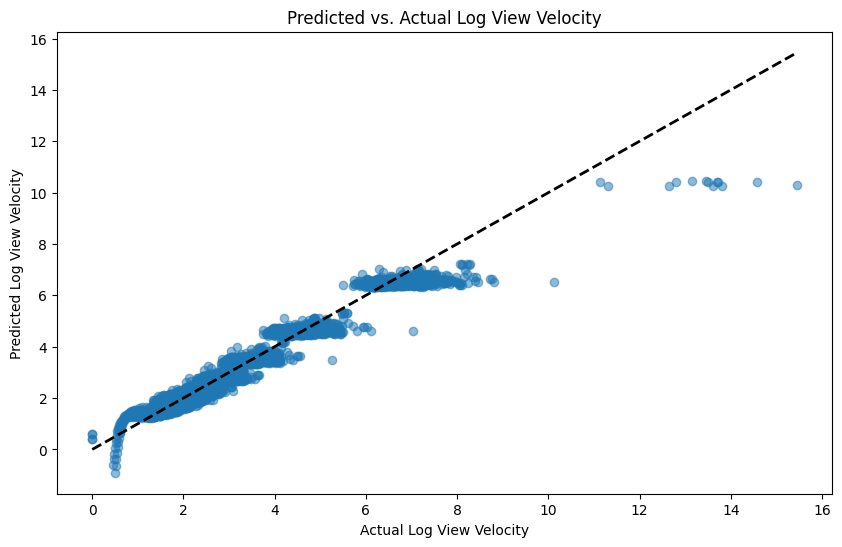

In [ ]:
# prompt: plot predicted vs actual values for the log view velocity from the model ran above

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Log View Velocity")
plt.ylabel("Predicted Log View Velocity")
plt.title("Predicted vs. Actual Log View Velocity")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Adding a diagonal line
plt.show()

# Data Exploration

In [ ]:
# prompt: Create a plot to pick number of videos published by a single channel over time showing the channel name in the plot title showing just the month day and year along the y axis in a readable way
# next prompt: Show the date less often in the above

import matplotlib.pyplot as plt
def show_number_of_videos_published_by_channel_over_time(data_df, rank):
  # Group the DataFrame by 'channelTitle' and count the number of videos published by each channel
  channel_video_counts = data_df.groupby('channelTitle')['title'].count().sort_values(ascending=False)

  # Select the top channel
  top_channel = channel_video_counts.index[rank]

  # Filter the DataFrame to include only videos published by the top channel
  top_channel_videos = data_df[data_df['channelTitle'] == top_channel]

  # Group the top channel videos by 'publishedAt' and count the number of videos published each day
  videos_published_over_time = top_channel_videos.groupby('publishedAt')['title'].count()

  # Create the plot
  plt.figure(figsize=(12, 6))
  plt.plot(videos_published_over_time.index.strftime('%m-%d-%Y'), videos_published_over_time.values)
  plt.xlabel('Date')
  plt.ylabel('Number of Videos Published')
  plt.title(f'Number of Videos Published by {top_channel} Over Time')
  plt.xticks(videos_published_over_time.index[::14].strftime('%m-%d-%Y'), rotation=45, ha='right')  # Show date every 14 days
  plt.tight_layout()
  plt.show()


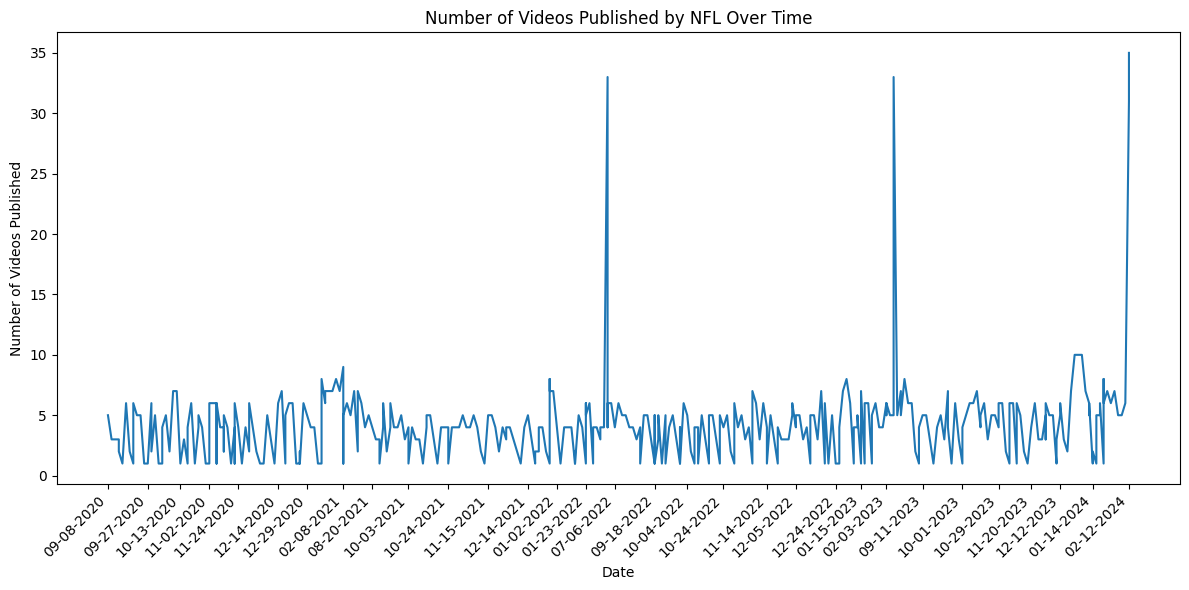

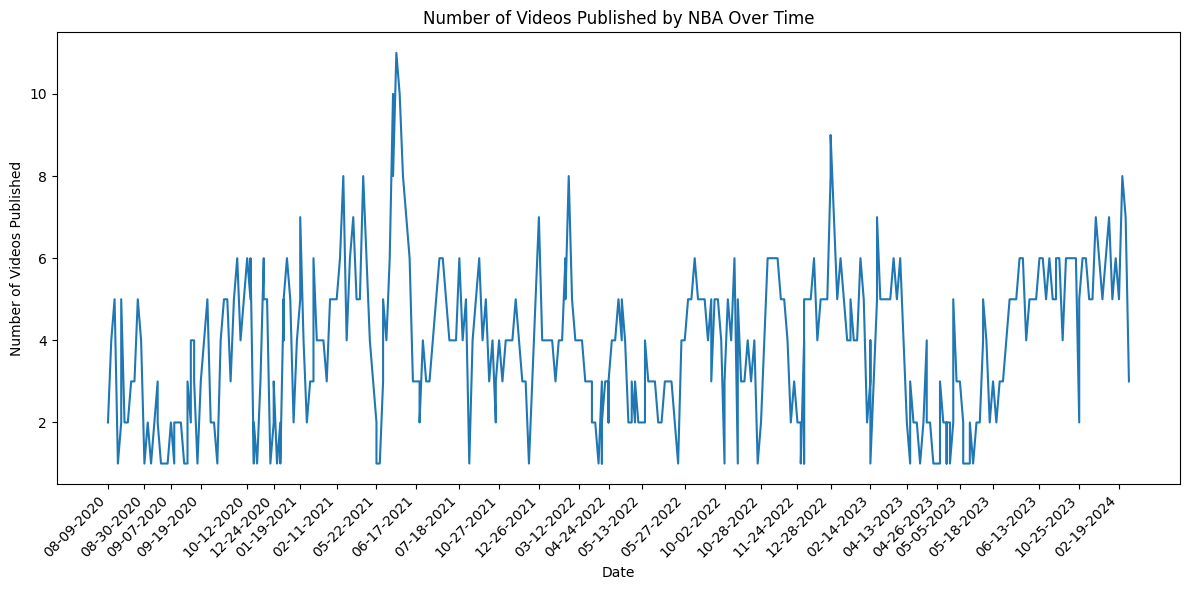

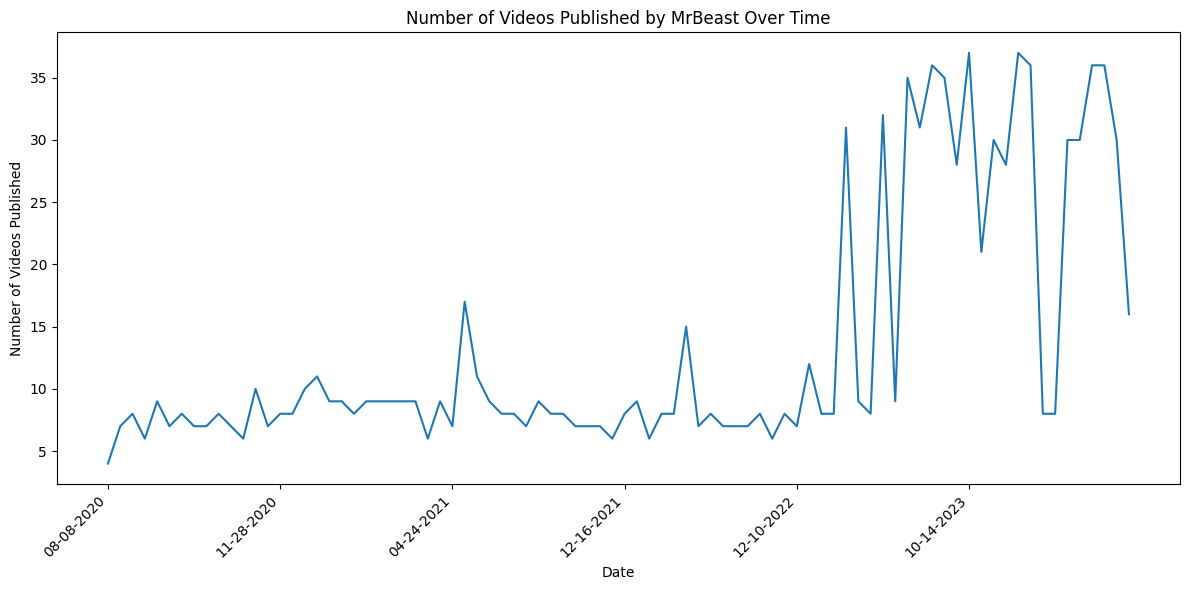

In [ ]:
show_number_of_videos_published_by_channel_over_time(data_df, 0)
show_number_of_videos_published_by_channel_over_time(data_df, 1)
show_number_of_videos_published_by_channel_over_time(data_df, 2)

In [ ]:
# prompt: Create a dataframe with just 2022 data

# Filter data for 2022
start_date = '2022-01-01'
end_date = '2022-12-31'
df_2022 = data_df[(data_df['publishedAt'] >= start_date) & (data_df['publishedAt'] <= end_date)]


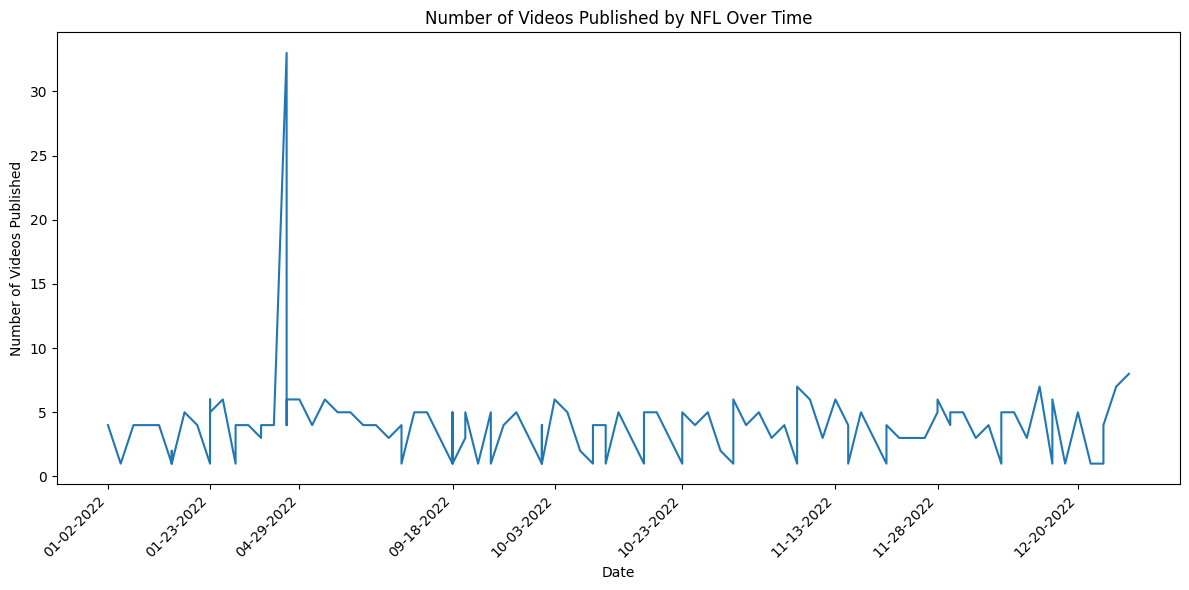

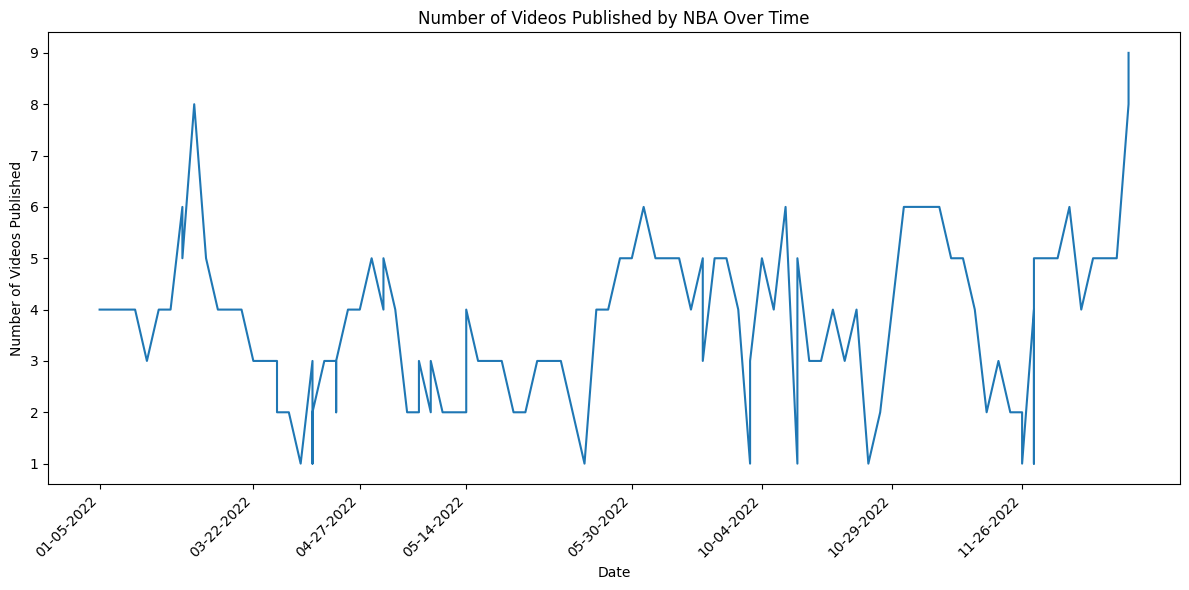

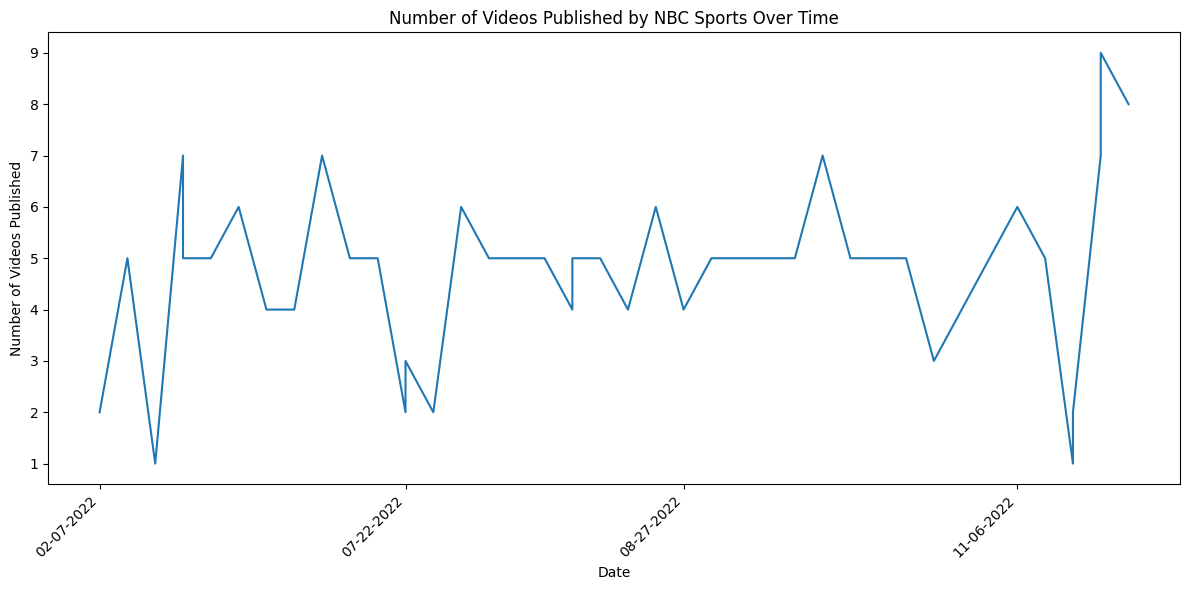

In [ ]:
show_number_of_videos_published_by_channel_over_time(df_2022, 0)
show_number_of_videos_published_by_channel_over_time(df_2022, 1)
show_number_of_videos_published_by_channel_over_time(df_2022, 2)

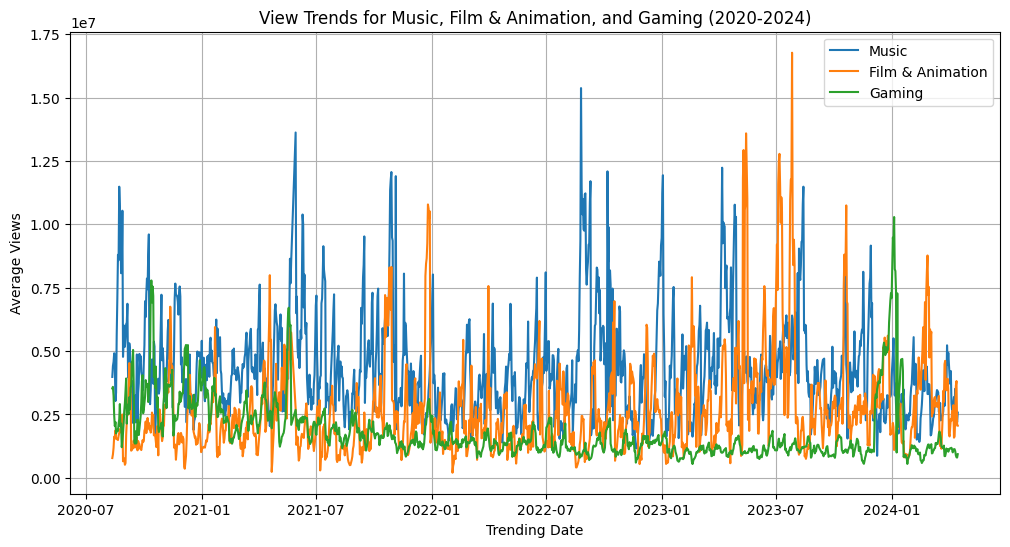

In [ ]:
# prompt: create a plot showing the trends of views for the categories music, Film & Animation, and gaming from 2020-2024

# Filter data for categories: Music, Film & Animation, Gaming
categories = ['Music', 'Film & Animation', 'Gaming']
filtered_df = data_df[data_df['categoryName'].isin(categories)]

# Group data by category and trending date, and calculate mean views
grouped_df = filtered_df.groupby(['categoryName', 'trending_date'])['view_count'].mean().reset_index()

# Plot trends for each category
plt.figure(figsize=(12, 6))
for category in categories:
  category_data = grouped_df[grouped_df['categoryName'] == category]
  plt.plot(category_data['trending_date'], category_data['view_count'], label=category)

plt.xlabel('Trending Date')
plt.ylabel('Average Views')
plt.title('View Trends for Music, Film & Animation, and Gaming (2020-2024)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# filter for 2020 data
start_date = '2020-01-01'
end_date = '2020-12-31'
df_2020 = data_df[(data_df['publishedAt'] >= start_date) & (data_df['publishedAt'] <= end_date)]

# filter for 2021 data
start_date = '2021-01-01'
end_date = '2021-12-31'
df_2021 = data_df[(data_df['publishedAt'] >= start_date) & (data_df['publishedAt'] <= end_date)]

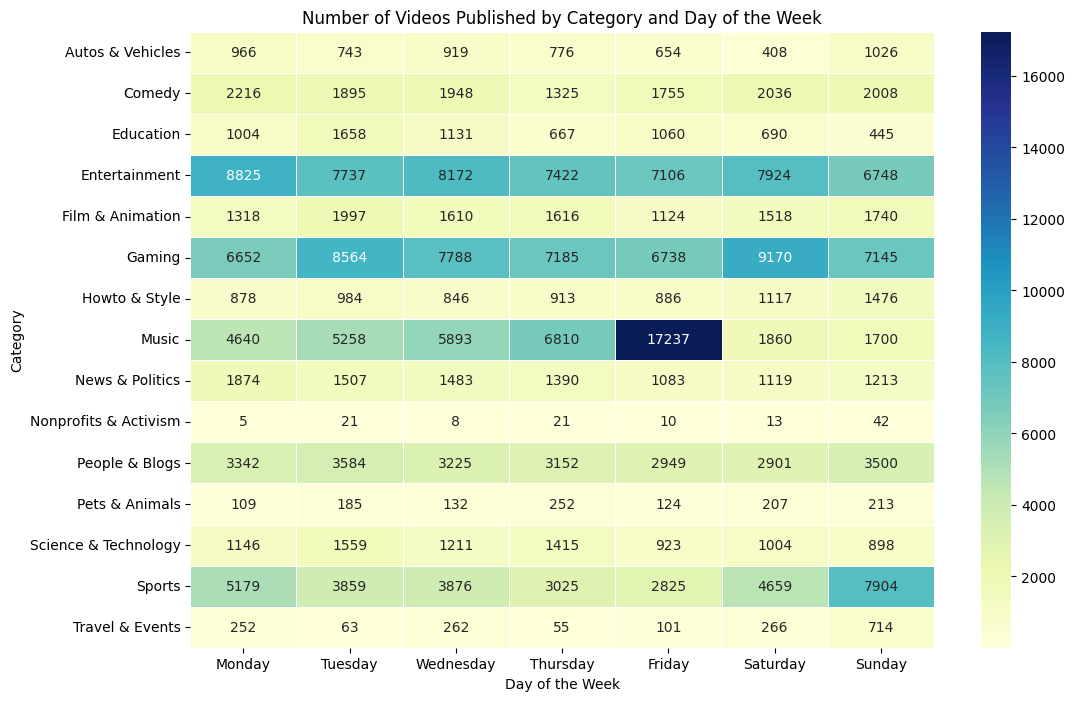

In [ ]:
# prompt: determine if categories of videos are being posted on a specific day in the week?

# Group the data by category and day of the week, and count the number of videos
category_day_counts = data_df.groupby(['categoryName', 'published_day_of_week'])['title'].count().unstack()

# Sort the days of the week in the correct order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
category_day_counts = category_day_counts[days_order]

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(category_day_counts, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)
plt.xlabel('Day of the Week')
plt.ylabel('Category')
plt.title('Number of Videos Published by Category and Day of the Week')
plt.show()


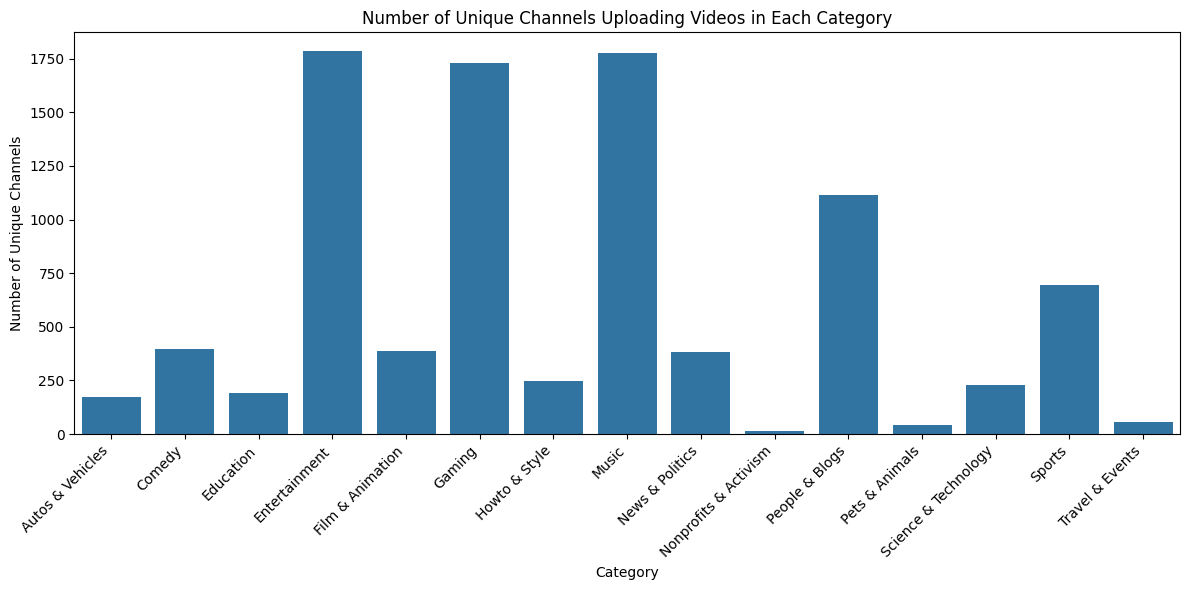

In [ ]:
# prompt: Plot: Bar chart or histogram
# Purpose: To see the number of videos uploaded by different channels within each category.
# X-axis: categoryName
# Y-axis: Count of videos or count of unique channelTitle

# Group the data by category and channel, and count the number of videos
category_channel_counts = data_df.groupby(['categoryName', 'channelTitle'])['title'].count().reset_index()

# Group the resulting DataFrame by category and count the number of unique channels
category_unique_channels = category_channel_counts.groupby('categoryName')['channelTitle'].nunique().reset_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='categoryName', y='channelTitle', data=category_unique_channels)
plt.xlabel('Category')
plt.ylabel('Number of Unique Channels')
plt.title('Number of Unique Channels Uploading Videos in Each Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# prompt: show me the video id of a music video by sabrina carpenter

# Filter for music videos by Sabrina Carpenter
sabrina_carpenter_music = data_df[
    (data_df['categoryName'] == 'Music') &
    (data_df['channelTitle'] == 'Sabrina Carpenter')
]

# Display the video IDs
print(sabrina_carpenter_music['video_id'])


KeyError: 'video_id'